### Install dependencies

In [17]:
%pip install -r requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 7.3 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 930 kB 38.5 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 23.9 MB/s  eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
Note: you may need to restart the kernel to use updated packages.


In [300]:
import re
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import pyplot as plt

from collections import Counter

### Read data from CSV

In [301]:
DATA = 'data/menuitems.csv'
df = pd.read_csv(DATA)
print(df.describe())

       Restaurant Name     Original food Item
count             4524                   4524
unique             341                   4330
top        Happy Joe's  Chocolate Chip Cookie
freq                48                     11


In [302]:
# Datafram columns:
RESTAURANT = 'Restaurant Name'
ITEM = 'Original food Item'
EMBEDDING = 'Embedding'
CLUSTER = 'Cluster'

### Data cleaning

Very basic, remove non-alphabetic characters and measure like fl oz and inch

In [307]:
def clean_item(item):
    # Remove these measures as they are creating spurious clusters
    rem = ['oz', 'fl', 'inch']
    for r in rem:
        p = r'\b' + re.escape(r) + r'\b'
        item = re.sub(p, '', item, flags=re.IGNORECASE)

    # Keep only alphabetical characters
    item = re.sub(r'[^a-zA-Z\s]', '', item)
    
    return item

df[ITEM] = df[ITEM].apply(lambda x: clean_item(x))

### Create sentence embeddings for menu items

Using sentence-transformers library and a popular BERT based model from Hugging Face to generate the vector representations of the menu items.

In [309]:
bert = 'bert-base-nli-stsb-mean-tokens'

sentence_transformer = SentenceTransformer(bert)
embeddings = sentence_transformer.encode(df[ITEM], show_progress_bar=True)
print(f"Embedding shape: {embeddings.shape}")

Batches: 100%|██████████| 142/142 [03:12<00:00,  1.36s/it]

Embedding shape: (4524, 768)


### Visualize embeddings

Visualize the embedding of the menu items using t-SNE. Couldn't see any clearly separated clusters in 2D using PCA, it was only capturing ~30% of the variance. So tried t-SNE, which shows more clearly separated clusters.

/opt/homebrew/anaconda3/envs/mic/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


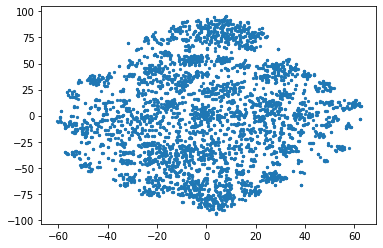

In [310]:
def visualize_embeddings(embeddings, size=10, labels=None):
    tsne = TSNE(n_components=2, learning_rate='auto')
    tsne_embeddings = tsne.fit_transform(embeddings)

    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=size, c=labels)
    plt.show()

visualize_embeddings(embeddings, size=5)

### Dimensionality reduction using PCA

Use PCA to reduce dimensionality while retaining 90% of variance in data.

In [311]:
pca = PCA(n_components=0.9, svd_solver='full')
dim_reduced_embeddings = pca.fit_transform(embeddings)
print(f"Dimension reduced embedding shape: {dim_reduced_embeddings.shape}")

df[EMBEDDING] = list(dim_reduced_embeddings)

Dimension reduced embedding shape: (4524, 119)


### Vector Representation of restaurants

Average the vectors of the menu items of each restaurant to create a vector representation of the restaurant.

In [312]:
restaurant_df = df.drop(columns=[ITEM])
restaurant_df = restaurant_df.groupby(RESTAURANT).mean().reset_index()

### Find the best number of clusters

Use silhouette score (higher the better) to find the best k.

https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

Silhouette scores: {5: 0.06836806, 6: 0.07046428, 7: 0.060130563, 8: 0.059894737, 9: 0.05671267, 10: 0.05130067, 11: 0.050933845, 12: 0.06390732, 13: 0.059980705, 14: 0.065121874, 15: 0.07385648, 16: 0.03090152, 17: 0.049014263, 18: 0.0636492, 19: 0.03480557, 20: 0.048534825, 21: 0.048413675, 22: 0.02724072, 23: 0.04672404, 24: 0.043913066, 25: 0.03299304, 26: 0.019919164, 27: 0.04475014, 28: 0.06434339, 29: 0.03152748}


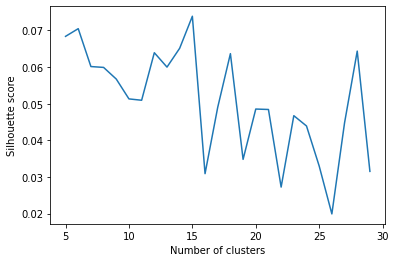

In [313]:
restaurant_embeddings = [embedding for embedding in restaurant_df[EMBEDDING].values]

candidate_k_values = list(range(5, 30))
slht_scores, kmeans_labels = [], []
for k in candidate_k_values: 
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(restaurant_embeddings)

    kmeans_labels.append(kmeans.labels_)
    slht_scores.append(silhouette_score(restaurant_embeddings, kmeans.labels_))

silhouette_score_dict = {candidate_k_values[i]: slht_scores[i] for i in range(len(slht_scores))}

print(f"Silhouette scores: {silhouette_score_dict}")

plt.plot(candidate_k_values, slht_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

### Label restaurants with clusters

In [314]:
best_k = 15
restaurant_df[CLUSTER] = kmeans_labels[best_k - candidate_k_values[0]]

### Visualize restaurant clusters

Not very well defined clusters, other than few of them at the edge.

/opt/homebrew/anaconda3/envs/mic/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


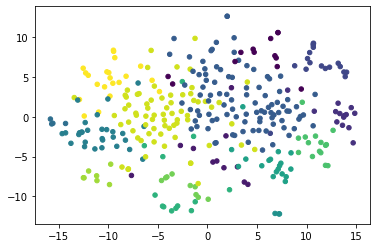

In [315]:
restaurant_embeddings = np.array(restaurant_embeddings)

visualize_embeddings(restaurant_embeddings, size=20, labels=restaurant_df[CLUSTER].values)

In [316]:
restaurant_df.sort_values(by=CLUSTER, inplace=True)
restaurant_df.to_csv('data/restaurants_clustered.csv', index=False, columns=[RESTAURANT, CLUSTER])

### Inspect clusters

Tried to look at what the most common words in the menu items for restaurants in each cluster are.

In [317]:

def most_common_words(x):
    word_salad = ' '.join(x.values).lower().split()
    ctr = Counter(word_salad)

    return ctr.most_common(3)

menuitems_clustered_df = df.merge(restaurant_df, on=RESTAURANT, how='left')
menuitems_clustered_df.groupby(CLUSTER)[ITEM].apply(most_common_words).reset_index()

,Cluster,Original food Item
0,0,"[(sauce, 17), (sweet, 6), (roasted, 6)]"
1,1,"[(cheese, 32), (pizza, 10), (cheddar, 10)]"
2,2,"[(chicken, 100), (breast, 22), (rice, 15)]"
3,3,"[(shrimp, 40), (salmon, 25), (wild, 19)]"
4,4,"[(chicken, 241), (with, 187), (sauce, 144)]"
5,5,"[(chocolates, 6), (dark, 4), (chocolate, 4)]"
6,6,"[(cream, 131), (ice, 116), (chocolate, 91)]"
7,7,"[(salsa, 3), (classic, 1), (gourmet, 1)]"
8,8,"[(pizza, 214), (crust, 76), (slice, 65)]"
9,9,"[(bread, 8), (rye, 6), (whole, 3)]"


### Cluster sizes

Few oddly small clusters (5, 7), and couple of large clusters (4, 13).

<AxesSubplot:>

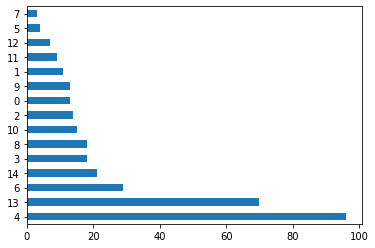

In [318]:
restaurant_df[CLUSTER].value_counts().plot(kind='barh')